# Sign spotting
This notebook trains the sign spotting model. We load in the data, split it into positive pairs (two data points of the same sign) and make batches using these pairs. After training the model, we create reference embeddings based on the train embeddings, where we average the 10% most representative train embeddings (those closest, on average, to all other train embeddings of the same sign) for each target sign to create that sign's reference. 

**Important note:** this notebook has to be run *thrice*, once for each **model_mode**.

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hides info/warning TF messages after this code block
import copy

import importlib

# Keep python tools up to date
from tools import tools, create_model, constants, sign_spot_tools
importlib.reload(tools)
importlib.reload(create_model)
importlib.reload(constants)
importlib.reload(sign_spot_tools)

# Import all functions from the tools
from tools.tools import load_dict, sec_to_timestamp
from tools.create_model import create_encoder
from tools.constants import PATHS, MODEL_PARAMS, USE_MOUTHINGS, ANN_LENGTH # constants
from tools.sign_spot_tools import*

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from collections import Counter

# Set a numpy seed for consistent results
np.random.seed(123)

In [2]:
# The metrics that we use, in a specific order (the order in which we print + store them)
metric_names = ['TP', 'FN', 'FP', 'TN', 'acc', 'prec', 'rec', 'f1']
thresh_list = [0.15, 0.2, 0.25, 0.3]
thresh_str = ['tol = ' + str(t) for t in thresh_list]
# Make columns for the metrics, per evaluation group (e.g. validation + test set)
metric_val = [m + ' (val)' for m in metric_names]
metric_test = [m + ' (test)' for m in metric_names]
metric_val_rand = [m + ' (val random)' for m in metric_names]
cols = ['Mode'] + metric_val + metric_test + metric_val_rand

# Get fixed tolerance window size
fixed_tolerance = ANN_LENGTH
tolerances = [fixed_tolerance]

In [3]:
# Make sure a folder exists for the results
if not os.path.exists('./results'):
    os.mkdir('results')

# Make a csv file to keep track of the results (load it if it exists)
results_path = './results/results_tol_{}.csv'.format(str(fixed_tolerance).replace('.', '_'))
if not os.path.exists(results_path):
    df = pd.DataFrame([], columns = cols)
    df.to_csv(results_path)
else:
    df = pd.read_csv(results_path)

In [4]:
%%time
model_mode = ['_only_lmrks', '_only_ling', '_combined'][0]
mouthings = USE_MOUTHINGS
mirror_aug = True
X_train, y_train, X_train_no_mirr, y_train_no_mirr, X_val, y_val, X_test, y_test, top = get_data(model_mode, mouthings)
# Compute how many unique classes there are
num_classes = len(set(y_train.tolist() + y_val.tolist() + y_test.tolist()))
print('\nNumber of classes (unique signs) in data:', num_classes)

,train,train_no_mirror,val,test
features shape,"(180432, 10, 84)","(90216, 10, 84)","(10295, 10, 84)","(9585, 10, 84)"
labels shape,"(180432,)","(90216,)","(10295,)","(9585,)"



Number of classes (unique signs) in data: 2712
CPU times: total: 3.33 s
Wall time: 3.12 s


In [5]:
ranges(y_train)

[(0, 2711)]

In [6]:
num_test_labels = len(set(y_test.tolist()))
num_val_labels = len(set(y_val.tolist()))
num_train_labels = len(set(y_train.tolist()))
print('Num of unique labels:')
print('Train: {:<4}\tVal: {:<4}\tTest: {:<4}'.format(num_train_labels, num_val_labels, num_test_labels))

Num of unique labels:
Train: 2712	Val: 1117	Test: 1038


In [7]:
# We use the training data without mirror augmentation if mirror_aug = False
if not mirror_aug:
    X_train = X_train_no_mirr
    y_train = y_train_no_mirr

In [8]:
# Shuffle the training data using indices
train_shuffle = np.random.choice(np.arange(y_train.shape[0]), y_train.shape[0], replace = False)
X_train, y_train = X_train[train_shuffle], y_train[train_shuffle]

In [9]:
# Getting an idea of which glosses are most common in the annotations
# Load in the (integer) labels with their gloss counterparts
label_path = PATHS['label_encoder'].format(top)
labels = load_dict(label_path)

# Count train labels, sort in desc. order (most common first) then select top 25 labels
top_items = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)[:25]

# The items are in the form (label, count) so we keep only the labels for now
top_labels = [x[0] for x in top_items]

# This matches the integer labels from the encoder to the top (integer) labels
target_labels = [x for x in labels.items() if x[1] in top_labels]

# We now grab the string equivalent of the integer labels, and get their frequency
fused = []
for target in target_labels:
    for item in top_items:
        int_label, count = item
        str_label, int_label_ = target
        if int_label == int_label_:
            fused.append((str_label, str(int_label), count))

# Prints triples of (gloss_name, gloss_integer_id, count)
print('Most common glosses as triple (string label, integer label, count)')
print(sorted(fused, key = lambda x: x[-1], reverse = True))

Most common glosses as triple (string label, integer label, count)
[('PT-1hand', '1867', 22896), ('PO', '1817', 17350), ('PT-1hand:1', '1868', 13514), ('GEBAREN-A', '778', 2552), ('PO+PT', '1818', 1902), ('GOED-A', '861', 1664), ('KUNNEN-A', '1251', 1520), ('HOREN-A', '1032', 1504), ('ATTENTIE', '213', 1496), ('WETEN-A', '2595', 1470), ('ZELFDE-A', '2645', 1320), ('ZIEN-A', '2677', 1226), ('1-A', '26', 1160), ('DOOF-A', '580', 1130), ('ZEGGEN', '2642', 1100), ('ZELF-A', '2643', 1092), ('NIET-A', '1539', 1042), ('HEE', '971', 1032), ('GAAN-NAAR-A', '771', 1022), ('NU-A', '1565', 930), ('MOETEN-A', '1452', 922), ('KIJKEN-A', '1161', 828), ('HEBBEN-A', '967', 808), ('LAAT-MAAR', '1266', 780), ('DOOF-B', '581', 778)]


# Creating batches

In [10]:
# Label frequencies within y_train
print(list(sorted(set(Counter(y_train).values()))))

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 210, 212, 214, 216, 220, 224, 226, 228, 234, 240, 242, 244, 248, 254, 256, 260, 262, 264, 266, 268, 270, 272, 280, 288, 290, 292, 294, 300, 304, 308, 318, 320, 324, 326, 336, 342, 344, 350, 354, 360, 366, 368, 372, 374, 376, 378, 386, 388, 400, 410, 416, 418, 420, 424, 432, 446, 452, 458, 466, 472, 474, 476, 480, 482, 484, 488, 504, 514, 518, 532, 534, 540, 546, 556, 558, 584, 588, 600, 614, 618, 652, 678, 684, 726, 736, 772, 778, 780, 808, 828, 922, 930, 1022, 1032, 1042, 1092, 1100, 1130, 1160, 1226, 1320, 1470, 1496, 1504, 1520, 1664

In [11]:
batch_size = MODEL_PARAMS['batch_size']
# window size aka how many instances of the same label/sign to group together
# ws = 2 is equal to making pairs of 2
ws = MODEL_PARAMS['window_size']

# Make a batch generator for the training, validation data
train_batch_gen = positive_pairs_batch_gen(X_train, y_train, batch_size = batch_size, window_size = ws)
val_batch_gen = positive_pairs_batch_gen(X_val, y_val, batch_size = batch_size, window_size = ws)

In [12]:
# # Checking label counts for each batch, to see if there's no extremely dominant labels
# # So we check how frequent each sign is per batch
# i = 0
# counts = []
# for x_batch, y_batch in train_batch_gen:
#     y_inds = []
#     for y in y_batch.numpy():
#         y_inds.append(y)
#     # Getting non-duplicate, sorted label counts
#     count = sorted(list(Counter(np.array(y_inds)).values()))
#     counts += count
#     i+=1

# print('Number of batches:', i)
# print('Label frequencies in the batches:', sorted(Counter(counts).items(), key = lambda x: x[0]))
# plt.figure(figsize=(4,2))
# plt.hist(counts, bins = batch_size)
# plt.xlabel('Number of instances of the same sign in batch')
# plt.ylabel('Frequency')
# plt.title('Label frequencies')
# plt.show()

In [13]:
# We pick a common sign here to see some plots of its embeddings similarity later
labels = load_dict(label_path)
target_num_label = labels['GEBAREN-A']
target_label = find_target_label(target_num_label, labels)

# Creating and training model

In [14]:
print('Model parameters:')
for param in MODEL_PARAMS:
    print(param, '=', MODEL_PARAMS[param])

Model parameters:
temperature = 0.07
batch_size = 128
window_size = 4
learning_rate = 0.001
bidirectional = True
masking = False
dense_size = 256
num_dense = 2
lstm_size = 128
num_lstm = 1
batch_normalisation = True
dropout = 0
lstm_dropout = False


In [15]:
# Setting some parameters
temperature = MODEL_PARAMS['temperature']
learning_rate = MODEL_PARAMS['learning_rate']
input_shape = X_train[0].shape
bidirectional = MODEL_PARAMS['bidirectional']
masking = MODEL_PARAMS['masking'] 
dense_size = MODEL_PARAMS['dense_size']
num_dense = MODEL_PARAMS['num_dense']
lstm_size = MODEL_PARAMS['lstm_size']
num_lstm = MODEL_PARAMS['num_lstm']
bn = MODEL_PARAMS['batch_normalisation']
dropout = MODEL_PARAMS['dropout']
lstm_dropout = MODEL_PARAMS['lstm_dropout']

# Whether to use sparse categorical cross entropy loss (note: does not work well if scce=True)
scce = False
final_activation = 'sigmoid'

dense_size_lst = [256,512,num_classes] if scce else []

# Add None to dims if first layer is bi-LSTM (requires specific shape)
if bidirectional and not masking:
    input_shape = (None,) + input_shape

print('Input shape:', input_shape)
# Instantiating the model
model = create_encoder(input_shape, bidirectional, masking, dropout, lstm_dropout, num_dense, num_lstm, dense_size, 
                       lstm_size, bn, dense_size_lst = dense_size_lst, final_activation = final_activation)
model.build(input_shape)
model.summary()

Input shape: (None, 10, 84)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 10, 84)           0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 256)              218112    
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                            

Epoch 1
1410/1410 [==============================] - 32s 17ms/step - loss: 0.6456 - val_loss: 0.5875
Ratio of randomly selected negative pairs >= 0.5: 0.002
Ratio of randomly selected positive pairs <= 0.5: 1.0
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


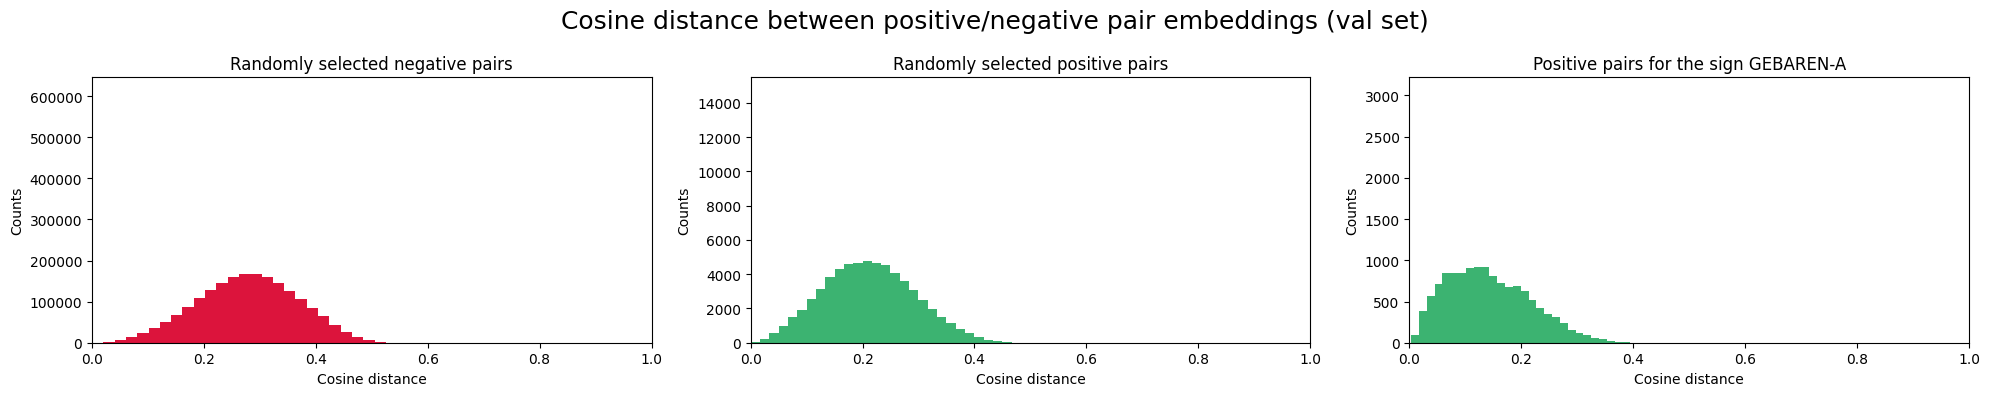

Epoch 2
1410/1410 [==============================] - 28s 15ms/step - loss: 0.6059 - val_loss: 0.5694
Ratio of randomly selected negative pairs >= 0.5: 0.013
Ratio of randomly selected positive pairs <= 0.5: 1.0
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


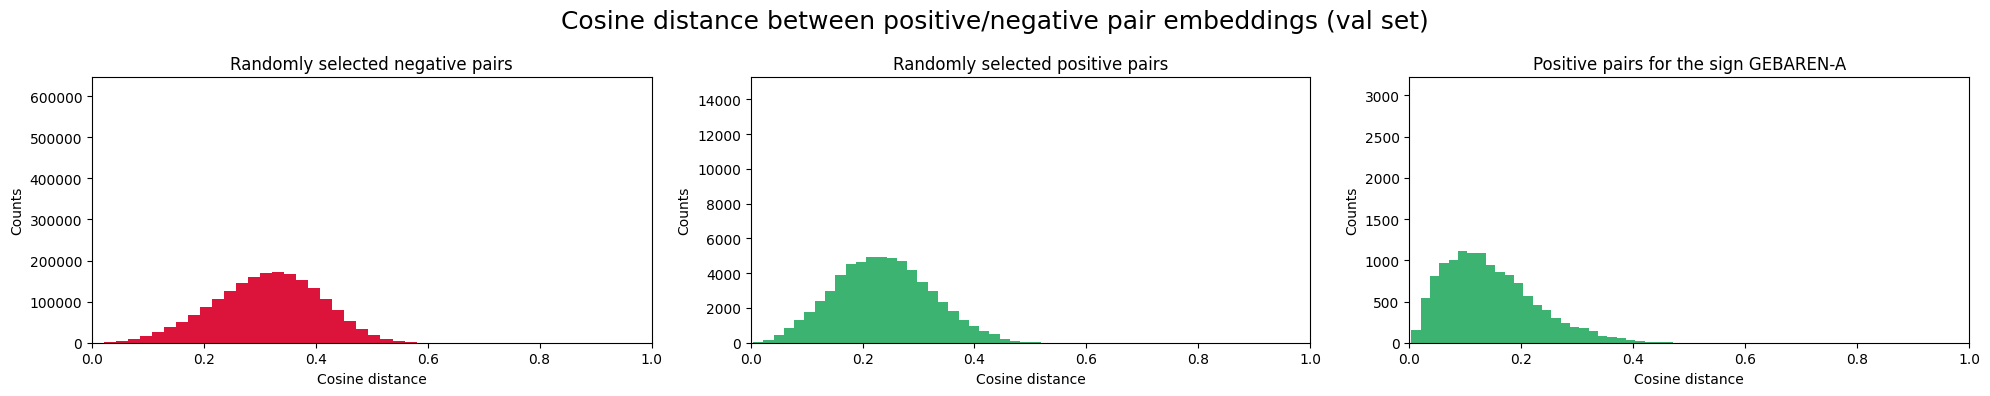

Epoch 3
1410/1410 [==============================] - 29s 17ms/step - loss: 0.5893 - val_loss: 0.5604
Ratio of randomly selected negative pairs >= 0.5: 0.026
Ratio of randomly selected positive pairs <= 0.5: 0.997
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


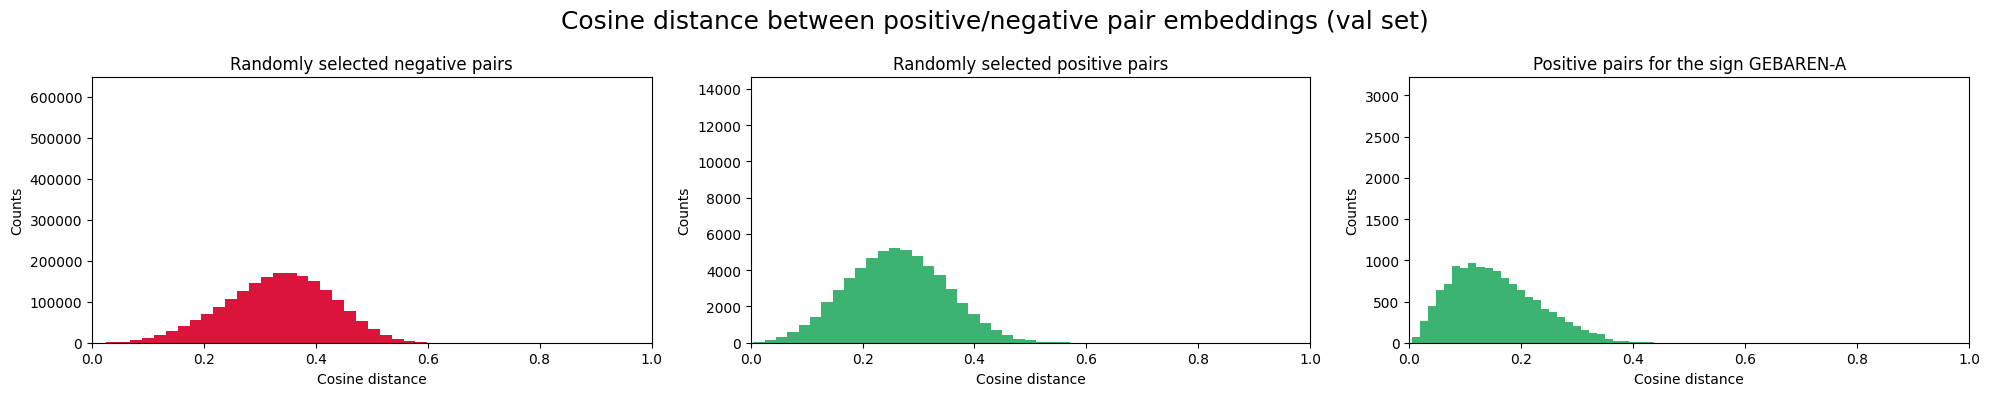

Epoch 4
1410/1410 [==============================] - 26s 15ms/step - loss: 0.5767 - val_loss: 0.5520
Ratio of randomly selected negative pairs >= 0.5: 0.05
Ratio of randomly selected positive pairs <= 0.5: 0.996
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


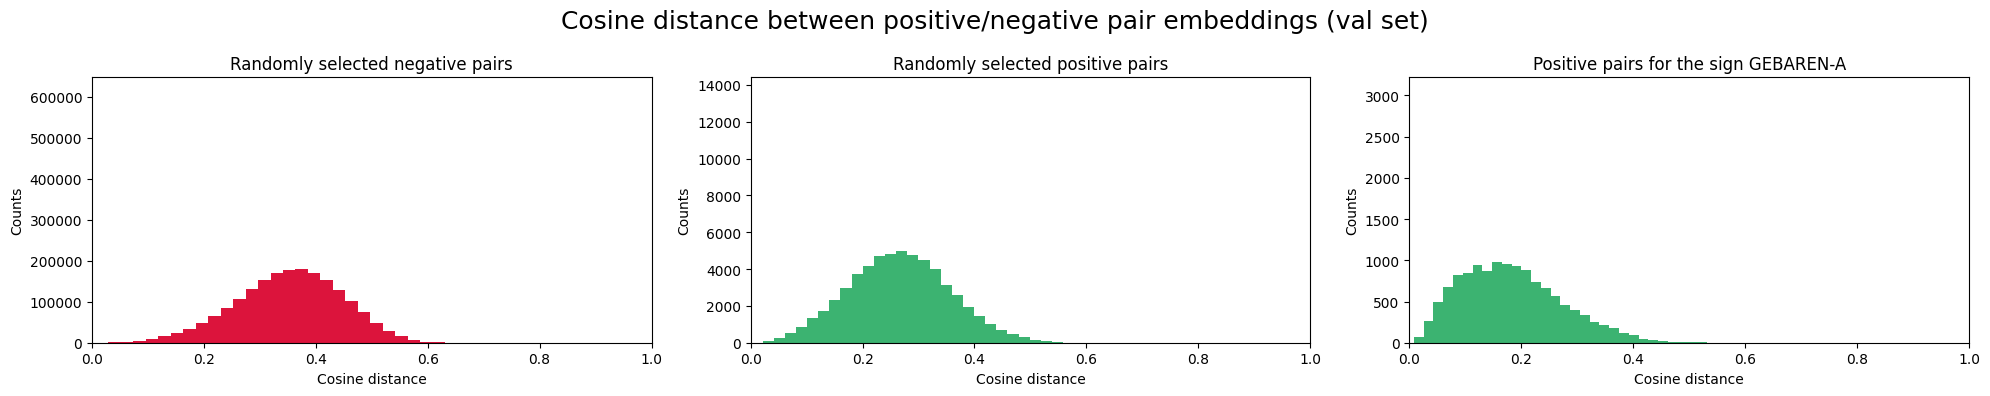

Epoch 5
1410/1410 [==============================] - 30s 18ms/step - loss: 0.5666 - val_loss: 0.5452
Ratio of randomly selected negative pairs >= 0.5: 0.068
Ratio of randomly selected positive pairs <= 0.5: 0.993
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


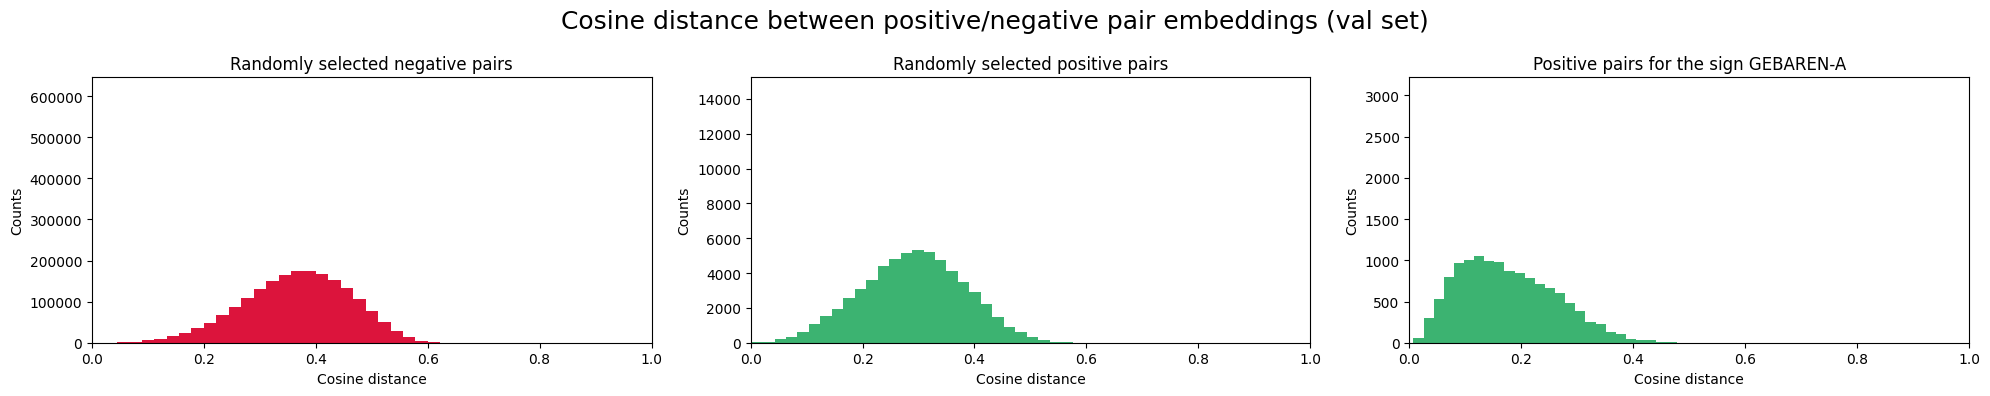

Epoch 6
1410/1410 [==============================] - 28s 15ms/step - loss: 0.5598 - val_loss: 0.5417
Ratio of randomly selected negative pairs >= 0.5: 0.09
Ratio of randomly selected positive pairs <= 0.5: 0.992
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


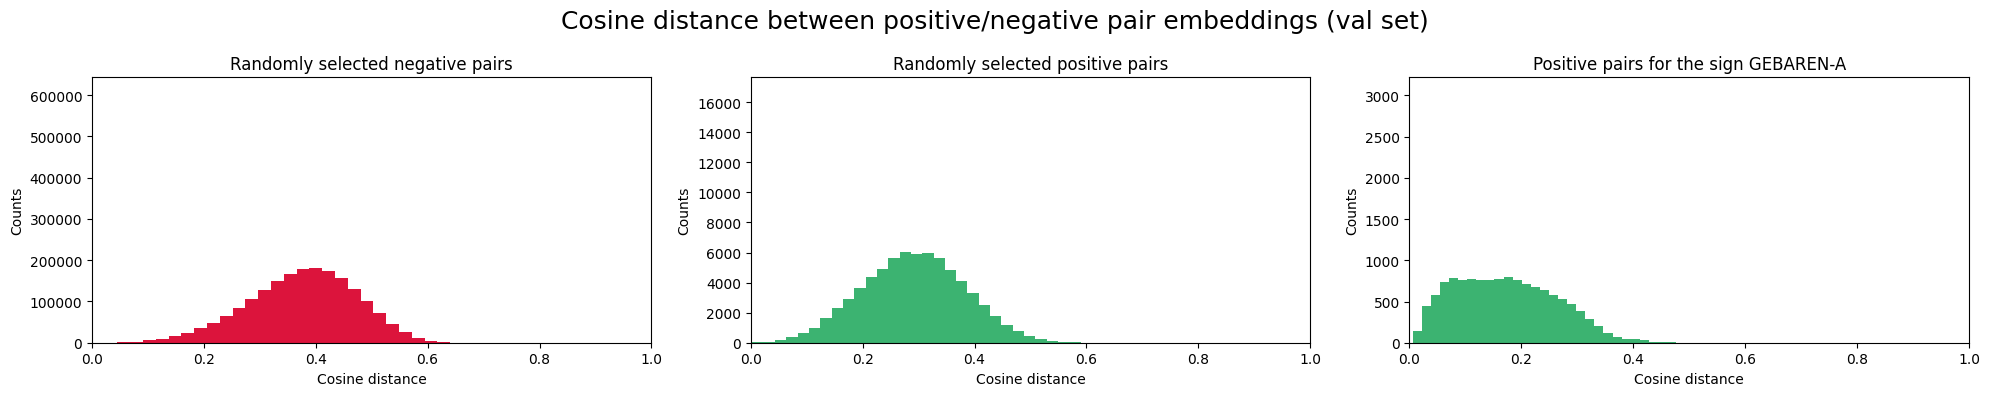

Epoch 7
1410/1410 [==============================] - 28s 16ms/step - loss: 0.5539 - val_loss: 0.5394
Ratio of randomly selected negative pairs >= 0.5: 0.112
Ratio of randomly selected positive pairs <= 0.5: 0.988
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


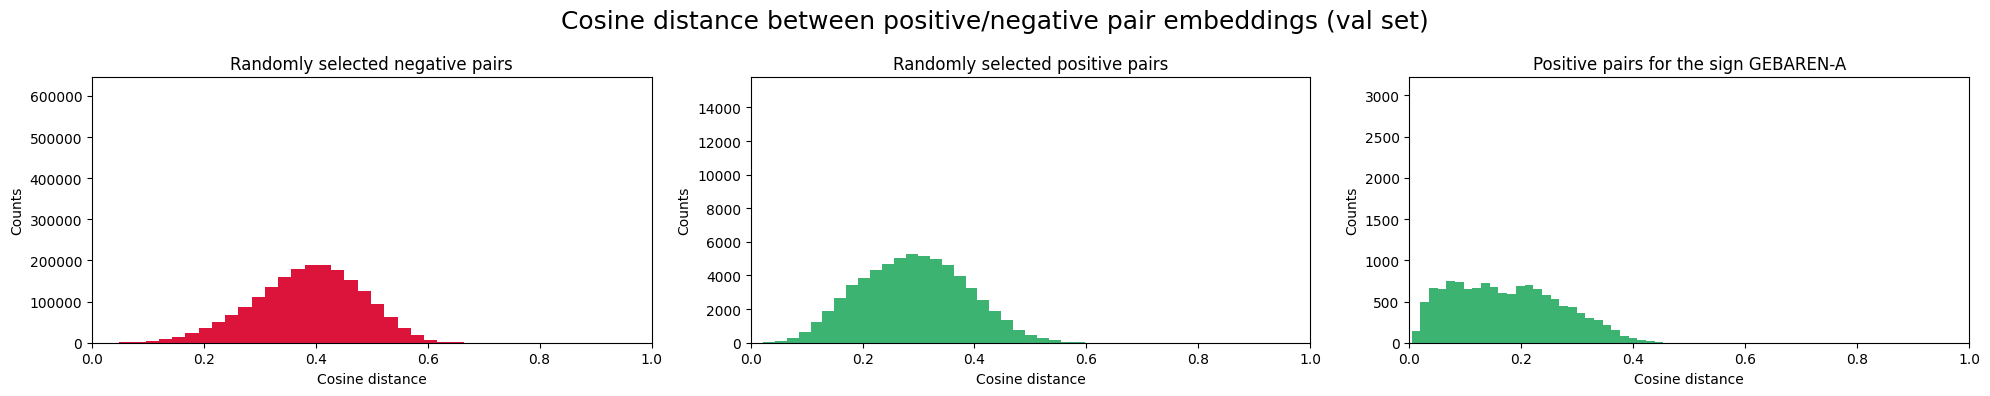

Epoch 8
1410/1410 [==============================] - 29s 16ms/step - loss: 0.5483 - val_loss: 0.5384
Ratio of randomly selected negative pairs >= 0.5: 0.151
Ratio of randomly selected positive pairs <= 0.5: 0.976
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


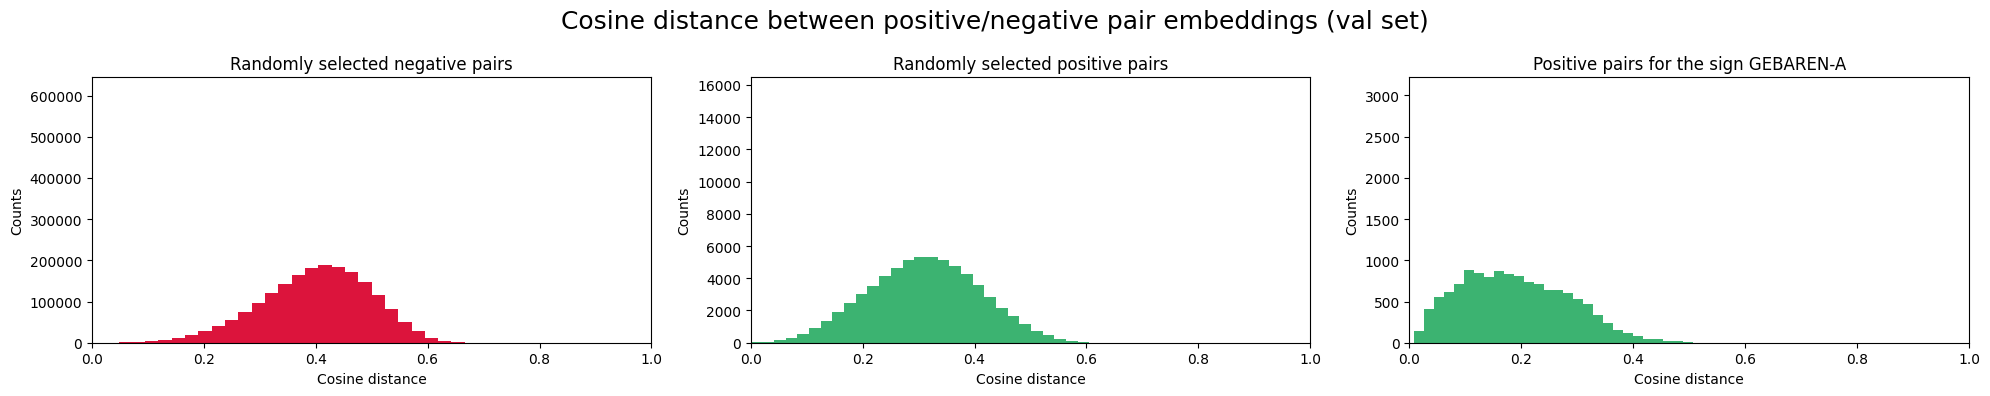

Epoch 9
1410/1410 [==============================] - 29s 16ms/step - loss: 0.5433 - val_loss: 0.5309
Ratio of randomly selected negative pairs >= 0.5: 0.162
Ratio of randomly selected positive pairs <= 0.5: 0.987
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.999


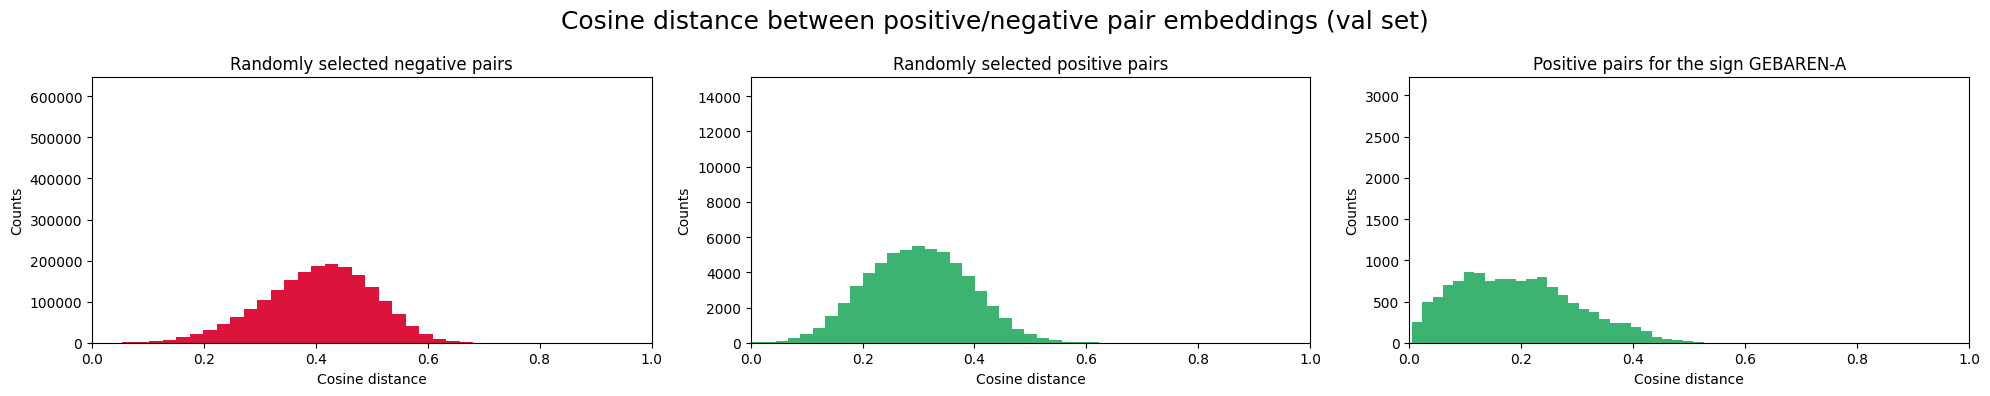

Epoch 10
1410/1410 [==============================] - 30s 17ms/step - loss: 0.5399 - val_loss: 0.5326
Ratio of randomly selected negative pairs >= 0.5: 0.208
Ratio of randomly selected positive pairs <= 0.5: 0.974
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.999


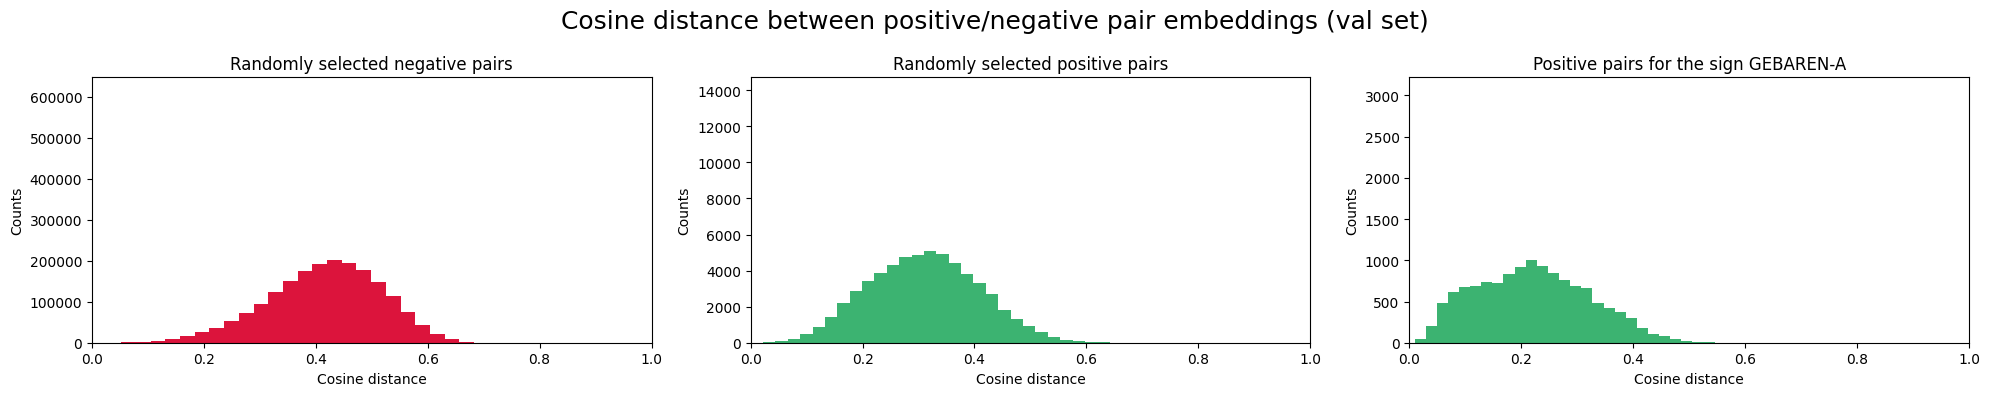

CPU times: total: 8min 7s
Wall time: 6min 24s


In [16]:
%%time
# For each epoch, we plot a sample from the val. set for the cosine distances between its embeddings
# There's three subplots: 1) all negative pairs in the sample, comparing embeddings of 2 different signs,
# 2) positive pairs of random signs in the sample, where we compare embeddings of the same sign,
# And 3) positive pairs for specifically a common sign (GEBAREN-A) in the data
# DISCLAIMER: the x-axis has the same scale for each subplot but the y-axis does NOT!
num_epochs = 10
val_losses, train_losses = train_model(model, train_batch_gen, val_batch_gen, X_train, y_train, X_val, y_val, labels,
                                       target_num_label, batch_size, learning_rate, temperature, num_epochs = num_epochs, 
                                       decay_rate = num_epochs, ws = ws, num_classes = num_classes, patience = num_epochs,
                                       scce=scce)

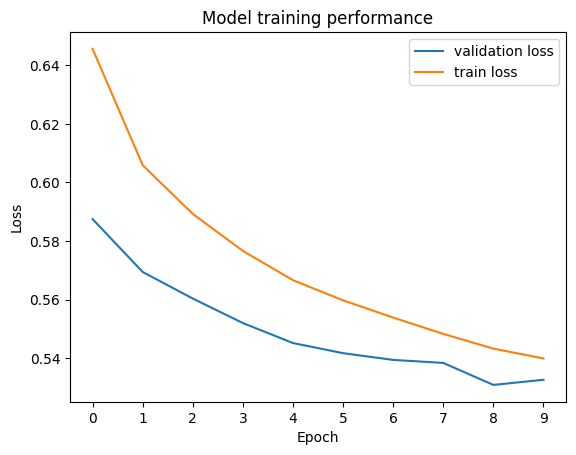

In [17]:
# Plotting the results
plt.title('Model training performance')
plt.plot(val_losses, label = 'validation loss')
plt.plot(train_losses, label = 'train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(val_losses)))
plt.legend()
plt.show()

Counts within test: [('PT-1hand', '1867 (int label)', 1057), ('PO', '1817 (int label)', 1001), ('PT-1hand:1', '1868 (int label)', 908), ('GEBAREN-A', '778 (int label)', 144), ('PO+PT', '1818 (int label)', 51), ('GOED-A', '861 (int label)', 100), ('KUNNEN-A', '1251 (int label)', 64), ('HOREN-A', '1032 (int label)', 82), ('ATTENTIE', '213 (int label)', 98), ('WETEN-A', '2595 (int label)', 62)]
Examples: (400, 10, 84)
Prediction result shape: (400, 256)


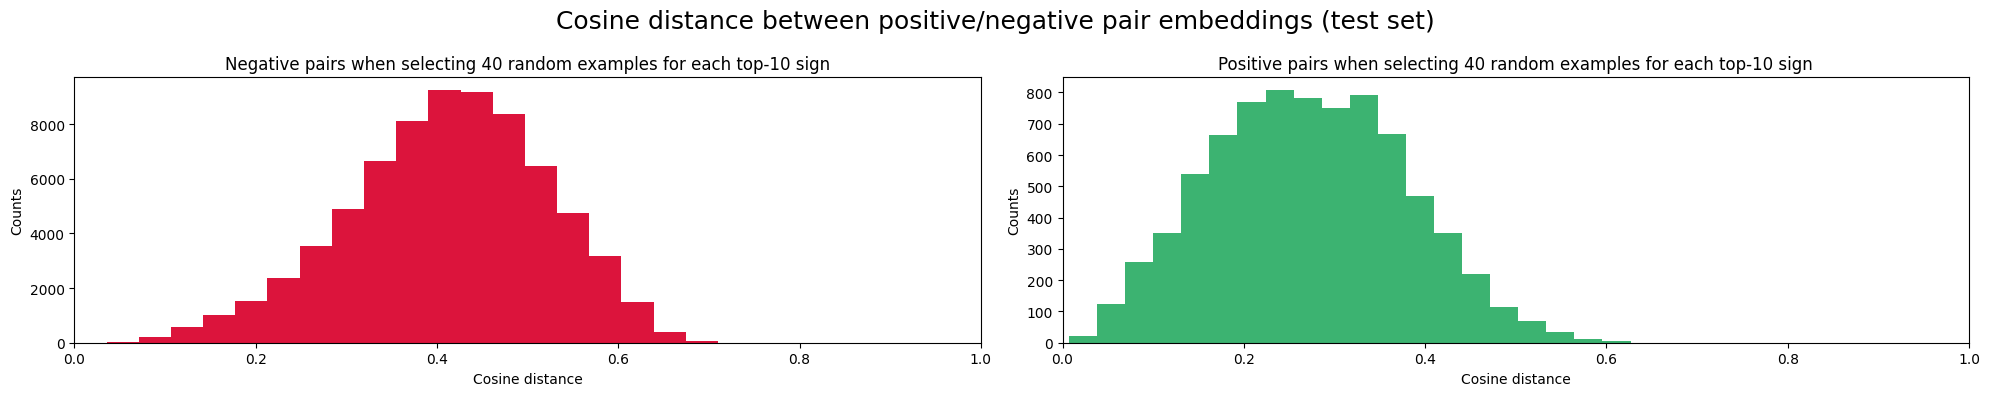

In [18]:
# We take 40 random signs for each of the top 10 most common signs
y_train_counts = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)
common_sign_sample = []
y_test_top_counts = []
for label, count in y_train_counts[:10]:
    label_inds = np.where(y_test == label)[0]
    str_label = find_target_label(label, labels)[0]
    y_test_top_counts.append((str_label,str(label) + ' (int label)', len(label_inds)))
    label_sample = np.random.choice(label_inds, 40, replace = False)
    common_sign_sample += label_sample.tolist()
print('Counts within test:', y_test_top_counts)
pos_cosines, neg_cosines = compute_cosines(model, common_sign_sample, X_test, y_test)    
    
# Use subplots to plot them next to each other
fig, ax = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle('Cosine distance between positive/negative pair embeddings (test set)', fontsize = 18)
# Random negative pairs
ax[0].hist(neg_cosines, bins = 20, color = 'crimson') # density = True, cumulative = True
ax[0].set_title('Negative pairs when selecting 40 random examples for each top-10 sign')
# Random positive pairs
ax[1].hist(pos_cosines, bins = 20, color = 'mediumseagreen') # density = True, cumulative = True
ax[1].set_title('Positive pairs when selecting 40 random examples for each top-10 sign')
for a in ax:
    a.set_xlim(0,1)
    a.set_ylabel('Counts')
    a.set_xlabel('Cosine distance')
#     a.set_yscale('log')
#     a.set_ylim(1, 10**5)
plt.tight_layout()
plt.show()

In [19]:
# Getting the counts of each label in the train set, then checking how many labels only occur once
train_label_counts = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)
print('Num. unique labels in train set:', len(train_label_counts), '\nNum. labels in train set only occuring once:',
      len([t for t in train_label_counts if t[-1] == 1]))

Num. unique labels in train set: 2712 
Num. labels in train set only occuring once: 0


# Creating reference embeddings

In [20]:
# We use only the non-mirrored, not augmented train data to make reference embeddings
y_train_labels = np.array(list(set(y_train_no_mirr)))

# Check here that the last dimension of X_train_no_mirr is the same as X_train!
# Otherwise, you may be using the wrong datasets together (i.e. completely different features)
print('Train data shape (no augmentation or mirroring):', X_train_no_mirr.shape)

Train data shape (no augmentation or mirroring): (90216, 10, 84)


In [21]:
%%time
# Create reference embeddings for all the signs
reference_sign_embds = ref_embds(model, X_train_no_mirr, y_train_no_mirr, y_train_labels, top_ratio = 0.1)

100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [00:48<00:00, 56.01it/s]

CPU times: total: 1min 7s
Wall time: 1min 3s


# Ranking

In [22]:
# Show the acc@k for the test set annotations (k = 30, 20, 10 and 5 tested)
# We find how often the train-learned reference embedding is ranked in the top-k most similar embeddings
# Compared to a test embedding of the same sign
X_test_pred = model.predict(X_test, verbose = 0)
top_k_ranking_acc(reference_sign_embds, X_test_pred, y_test, y_train_labels, k_vals = [30,20,10,5])

100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [00:32<00:00, 82.83it/s]

Number of target signs ranked in top 30: 5042/9585
accuracy@30: 52.6%
Number of target signs ranked in top 20: 4490/9585
accuracy@20: 46.84%
Number of target signs ranked in top 10: 3680/9585
accuracy@10: 38.39%
Number of target signs ranked in top 5: 2897/9585
accuracy@5: 30.22%


# Sliding window example

In [23]:
# Get the reference embedding for our common sign example (e.g. 'GEBAREN-A')
reference_res = reference_sign_embds[target_num_label]

In [24]:
%%time
# Load in the features for later use (saves some time to do it here)
# Note: always pass a deep copy of this dictionary to ensure you don't alter it!
features_path = PATHS['features_data'].format(model_mode)
features_data = dict(np.load(features_path, allow_pickle = True))

CPU times: total: 547 ms
Wall time: 529 ms


In [25]:
%%time
# Get the embedding of an entire target video
target_video = 'S053_CNGT1206.eaf' #'S011_CNGT0215' #'S002_CNGT0092'
print('Corpus target video:', target_video)  
# Get the embedding of each video in the test set using a sliding window
anns, video_embd_dict = make_video_embds(model, model_mode, mouthings, select_video = target_video, 
                                         features_data = copy.deepcopy(features_data))

Corpus target video: S053_CNGT1206.eaf
Loading annotations and getting test video ids...
Loading test video features...


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.01it/s]


Creating embeddings...
Batch shape: (7315, 10, 84)


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 42.47it/s]


Number of embeds: (7315, 256)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.67it/s]

Done.                                                                                                    
CPU times: total: 2 s
Wall time: 2.19 s


In [26]:
# Get video embedding of the target video
result = video_embd_dict[target_video]
anns_dict = anns[target_video]
# Compute the distance of our target sign's reference embedding over the entire target video
dist = cdist(result, reference_res.reshape(1,-1), metric = 'cosine').flatten()

In [27]:
# Get the length of the target video in milliseconds
# We add +3 seconds because the Corpus videos start with a 3 second disclaimer
max_ms = int((3+result.shape[0]/25)*1000)

# Find where the target occurs in the video
if target_label[0] in anns_dict:
    target_times = anns_dict[target_label[0]]
    target_times = list(set(target_times))
    print('Found target times for {}: {}'.format(target_label[0], target_times))
else: # If the target sign is not present, we give out a warning
    print('Warning: target sign {} does not occur in corpus video {}'.format(target_label[0], target_video))
    target_times = []

Found target times for GEBAREN-A: [(6888, 6894), (5548, 5572)]


Frame with smallest distance: 5556 (timestamp 0:03:45)
Video: S053_CNGT1206.eaf


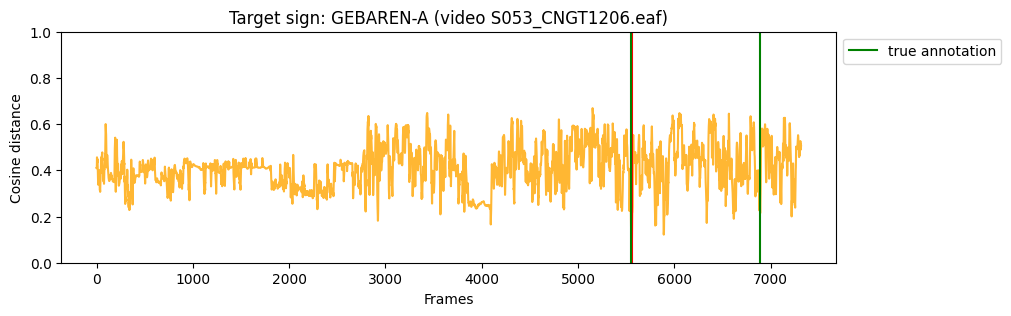

Annotation #1 of GEBAREN-A: 0:00:07-0:00:07
target frames: (6888, 6894)


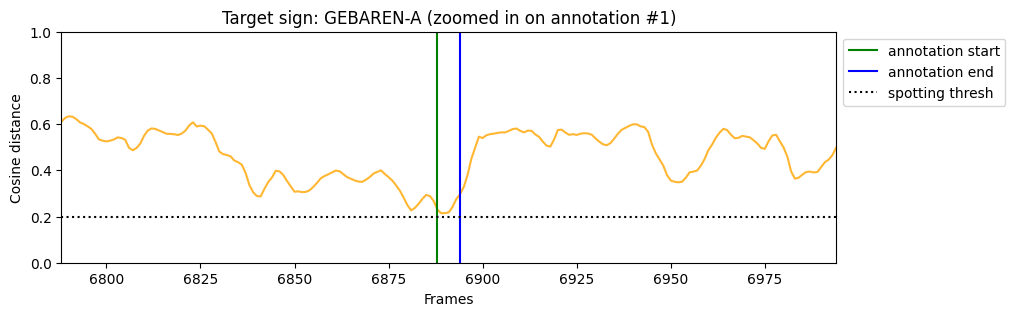

Annotation #2 of GEBAREN-A: 0:00:06-0:00:06
target frames: (5548, 5572)


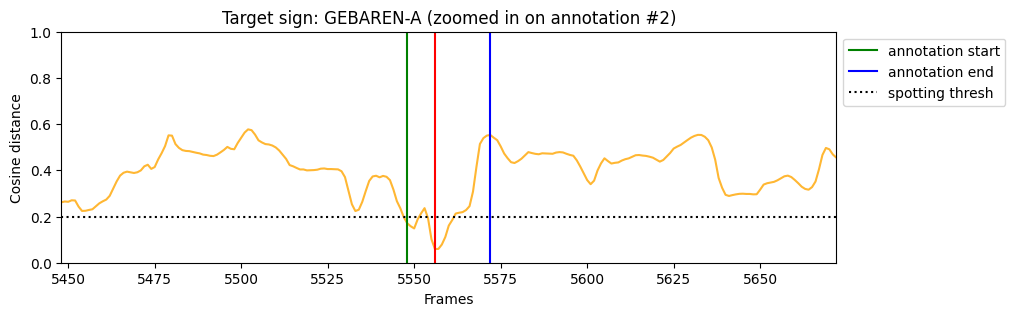

In [28]:
# Setting some default plotting settings that apply both for zoomed out and zoomed in plots
def default_plot_settings(dist, target_sign, title_str, xlim = None, ):
    plt.figure(figsize=(10,3))
    title = 'Target sign: ' + target_sign + ' ' + title_str
    plt.title(title)
    # Plot the distances
    plt.plot(dist, color = '#FFA500', alpha = 0.8)
    plt.ylim(0,1)
    # Add line at minimum distance
    plt.axvline(x = np.argmin(dist), color = 'r')   #, label = 'lowest distance' 
    
    if xlim: 
        plt.xlim(xlim[0], xlim[1]) 

#Draw lines at the start and end of each labeled instance of the target sign
window = 100 # 15

# Get where the distance is minimal, draw a line there
min_dist = np.argmin(dist)
min_dist_sec = round(3+min_dist/25) # Convert to seconds
print('Frame with smallest distance: {} (timestamp {})'.format(min_dist, sec_to_timestamp(min_dist_sec)))

print('Video:', target_video)

# First, we plot the full video
default_plot_settings(dist, target_label[0], '(video {})'.format(target_video))
for i, target_time in enumerate(target_times):
    # Convert the target times to frames, plot their starting times
    target_frames = (target_time[0], target_time[1])
    # We only add a label for the first ann so the legend doesn't list the same thing multiple times
    plt.axvline(x = target_frames[0], color = 'g', label = 'true annotation' if i == 0 else None)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 
plt.xlabel('Frames')
plt.ylabel('Cosine distance')
plt.show()


# Zooming in on specific annotations
for i, target_time in enumerate(target_times):
    
    # Get the start and end timestamps
    start_ts, end_ts = sec_to_timestamp(round(target_time[0]/1000)), sec_to_timestamp(round(target_time[1]/1000))
    print('Annotation #{} of {}: {}-{}'.format(i+1, target_label[0], start_ts, end_ts))

    # Convert the target times to frames, plot their starting times *and* ending times
    target_frames = (target_time[0], target_time[1])
    xlim = (max(0, target_frames[0]-window), min(max_ms, target_frames[1]+window)) 
    default_plot_settings(dist, target_label[0], '(zoomed in on annotation #{})'.format(i+1), xlim = xlim)
    
    print('target frames:', target_frames)
    # We zoom in on an annotation, adding lines where it's annotated
    plt.axvline(x = target_frames[0], color = 'g', label = 'annotation start')
    plt.axvline(x = target_frames[1], color = 'b', label = 'annotation end')
    plt.axhline(y = 0.2, color='k', linestyle=':', label = 'spotting thresh')
#     plt.xlim(xlim[0], xlim[1]) 
    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left") 
    plt.xlabel('Frames')
    plt.ylabel('Cosine distance')
    plt.show()

# Validation set analysis

In [29]:
# Get the embedding of each video in the validation set using a sliding window
val_anns, val_video_embd_dict = make_video_embds(model, model_mode, mouthings, test_videos = False,
                                                 features_data = copy.deepcopy(features_data))

Loading annotations and getting val video ids...
Loading val video features...


100%|███████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 420.11it/s]


Creating embeddings...
Batch shape: (388794, 10, 84)


100%|██████████████████████████████████████████████████████████████████████████████| 3038/3038 [00:57<00:00, 53.10it/s]


Number of embeds: (388794, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:03<00:00, 37.14it/s]


Done.                                                                                                    


In [30]:
%%time
unknowns_as_distant = False
df_path = 'linguistic_distance_df_v2' if unknowns_as_distant else 'linguistic_distance_df'
dist_df = pd.read_csv(PATHS['linguistic_distance_df'], index_col = 0)
display(dist_df.head())

# Get the distractor's in terms of their timestamps, glosses/signs and their distance to the target sign
distractor_times, distractor_glosses, linguistic_distances = get_distractors(val_anns, labels, dist_df, 
                                                                            tolerance = max(tolerances), 
                                                                            balanced = False, random = False)

,AUKE-KUITERT-B,ABBE-DE-L'EPEE,VERANTWOORDELIJK,JAM-A,LAATSTE-A,LAATSTE-B,VERZEKERING,RIJLES,STATION-B,TROTS-A,...,AANVALLEN-ELKAAR-A,DIALECT-C,POLITIEBUREAU-B,SCHOENMAKER-C,ONBEWUST-A,ONBEWUST-B,X-B,JOEGOSLAVIE-B,HEEL-HOOG,PLUKKEN
AUKE-KUITERT-B,0.0,10.0,9.0,12.0,11.0,11.0,11.0,11.0,10.0,8.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0
ABBE-DE-L'EPEE,10.0,0.0,7.0,10.0,7.0,9.0,8.0,6.0,7.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,10.0
VERANTWOORDELIJK,9.0,7.0,0.0,9.0,8.0,8.0,7.0,6.0,7.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,8.0
JAM-A,12.0,10.0,9.0,0.0,10.0,8.0,7.0,10.0,9.0,10.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,11.0
LAATSTE-A,11.0,7.0,8.0,10.0,0.0,6.0,6.0,5.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,11.0


CPU times: total: 7.98 s
Wall time: 7.99 s


In [31]:
# %%time
# Fixed window of tolerance, instead fluctuating the threshold of spotting
val_results_list = []

# Showing performance for different spotting thresholds
print('Tolerance (in frames):', fixed_tolerance)
for t in thresh_list: 
    fp_instances, results = distractor_based_eval(val_anns, val_video_embd_dict, reference_sign_embds, 
                                                                   labels, distractor_times, distractor_glosses, 
                                                                   spotting_thresh = t, tolerance = fixed_tolerance)
    val_results_list.append(results)

Tolerance (in frames): 10


In [32]:
val_df = pd.DataFrame(val_results_list, columns = metric_names, index = thresh_str)
display(val_df)

,TP,FN,FP,TN,acc,prec,rec,f1
tol = 0.15,4339,6261,1026,9565,0.656,0.809,0.409,0.543
tol = 0.2,5845,4755,1979,8612,0.682,0.747,0.551,0.634
tol = 0.25,6718,3882,2895,7696,0.680,0.699,0.634,0.665
tol = 0.3,6840,3760,3739,6852,0.646,0.647,0.645,0.646


In [33]:
acc_at_tol = val_df['acc']['tol = 0.2']
print(acc_at_tol)

0.682


In [34]:
# Make sure the checkpoint folder exists, otherwise create it
if not os.path.exists(PATHS['checkpoint_root']):
    os.mkdir(PATHS['checkpoint_root'])

model_path = PATHS['model_checkpoint'].format(model_mode)
# Save model in checkpoint folder
model.save(model_path + '_val_acc_' + str(acc_at_tol))

INFO:tensorflow:Assets written to: ./model_checkpoints/model_only_lmrks_val_acc_0.682\assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model_only_lmrks_val_acc_0.682\assets


In [35]:
%%time
unknowns_as_distant = False
df_path = 'linguistic_distance_df_v2' if unknowns_as_distant else 'linguistic_distance_df'
dist_df = pd.read_csv(PATHS['linguistic_distance_df'], index_col = 0)
display(dist_df.head())

# Get the distractor's in terms of their timestamps, glosses/signs and their distance to the target sign
distractor_times, distractor_glosses, linguistic_distances = get_distractors(val_anns, labels, dist_df, 
                                                                            tolerance = max(tolerances), 
                                                                            balanced = False, random = True)

,AUKE-KUITERT-B,ABBE-DE-L'EPEE,VERANTWOORDELIJK,JAM-A,LAATSTE-A,LAATSTE-B,VERZEKERING,RIJLES,STATION-B,TROTS-A,...,AANVALLEN-ELKAAR-A,DIALECT-C,POLITIEBUREAU-B,SCHOENMAKER-C,ONBEWUST-A,ONBEWUST-B,X-B,JOEGOSLAVIE-B,HEEL-HOOG,PLUKKEN
AUKE-KUITERT-B,0.0,10.0,9.0,12.0,11.0,11.0,11.0,11.0,10.0,8.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0
ABBE-DE-L'EPEE,10.0,0.0,7.0,10.0,7.0,9.0,8.0,6.0,7.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,10.0
VERANTWOORDELIJK,9.0,7.0,0.0,9.0,8.0,8.0,7.0,6.0,7.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,8.0
JAM-A,12.0,10.0,9.0,0.0,10.0,8.0,7.0,10.0,9.0,10.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,11.0
LAATSTE-A,11.0,7.0,8.0,10.0,0.0,6.0,6.0,5.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,11.0


CPU times: total: 7.67 s
Wall time: 7.69 s


In [36]:
%%time
# Fixed window of tolerance, instead fluctuating the threshold of spotting
val_results_list_rand = []

# Showing performance for different tolerances
print('Tolerance (in frames):', fixed_tolerance)
for t in thresh_list: 
    fp_instances, results = distractor_based_eval(val_anns, val_video_embd_dict, reference_sign_embds, 
                                                                   labels, distractor_times, distractor_glosses, 
                                                                   spotting_thresh = t, tolerance = fixed_tolerance)
    val_results_list_rand.append(results)

Tolerance (in frames): 10
CPU times: total: 25.4 s
Wall time: 25.6 s


In [37]:
pd.DataFrame(val_results_list_rand, columns = metric_names, index = thresh_str)

,TP,FN,FP,TN,acc,prec,rec,f1
tol = 0.15,4339,6261,435,10156,0.684,0.909,0.409,0.564
tol = 0.2,5845,4755,968,9623,0.730,0.858,0.551,0.671
tol = 0.25,6718,3882,1662,8929,0.738,0.802,0.634,0.708
tol = 0.3,6840,3760,2412,8179,0.709,0.739,0.645,0.689


# Test set evaluation


In [38]:
# Get the embedding of each video in the validation set using a sliding window
test_anns, test_video_embd_dict = make_video_embds(model, model_mode, mouthings, test_videos = True,
                                                 features_data = copy.deepcopy(features_data))

unknowns_as_distant = False
df_path = 'linguistic_distance_df_v2' if unknowns_as_distant else 'linguistic_distance_df'
dist_df = pd.read_csv(PATHS['linguistic_distance_df'], index_col = 0)
display(dist_df.head())

# Get the distractor's in terms of their timestamps, glosses/signs and their distance to the target sign
distractor_times, distractor_glosses, linguistic_distances = get_distractors(test_anns, labels, dist_df, 
                                                                             tolerance = max(tolerances), 
                                                                            balanced = False, random = False)

# Fixed window of tolerance, instead fluctuating the threshold of spotting
test_results_list = []

# Showing performance for different tolerances
print('Tolerance (in frames):', fixed_tolerance)
for t in thresh_list: 
    fp_instances, results = distractor_based_eval(test_anns, test_video_embd_dict, reference_sign_embds, 
                                                                   labels, distractor_times, distractor_glosses, 
                                                                   spotting_thresh = t, tolerance = fixed_tolerance)
    test_results_list.append(results)

Loading annotations and getting test video ids...
Loading test video features...


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 307.39it/s]


Creating embeddings...
Batch shape: (415003, 10, 84)


100%|██████████████████████████████████████████████████████████████████████████████| 3243/3243 [01:03<00:00, 50.79it/s]


Number of embeds: (415003, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 31.25it/s]


Done.                                                                                                    


,AUKE-KUITERT-B,ABBE-DE-L'EPEE,VERANTWOORDELIJK,JAM-A,LAATSTE-A,LAATSTE-B,VERZEKERING,RIJLES,STATION-B,TROTS-A,...,AANVALLEN-ELKAAR-A,DIALECT-C,POLITIEBUREAU-B,SCHOENMAKER-C,ONBEWUST-A,ONBEWUST-B,X-B,JOEGOSLAVIE-B,HEEL-HOOG,PLUKKEN
AUKE-KUITERT-B,0.0,10.0,9.0,12.0,11.0,11.0,11.0,11.0,10.0,8.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0
ABBE-DE-L'EPEE,10.0,0.0,7.0,10.0,7.0,9.0,8.0,6.0,7.0,8.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,3.0,10.0
VERANTWOORDELIJK,9.0,7.0,0.0,9.0,8.0,8.0,7.0,6.0,7.0,4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,8.0
JAM-A,12.0,10.0,9.0,0.0,10.0,8.0,7.0,10.0,9.0,10.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,11.0
LAATSTE-A,11.0,7.0,8.0,10.0,0.0,6.0,6.0,5.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,11.0


Tolerance (in frames): 10


In [39]:
pd.DataFrame(test_results_list, columns = metric_names, index = thresh_str)

,TP,FN,FP,TN,acc,prec,rec,f1
tol = 0.15,3862,5846,970,8717,0.649,0.799,0.398,0.531
tol = 0.2,5237,4471,1750,7937,0.679,0.750,0.539,0.627
tol = 0.25,6108,3600,2635,7052,0.679,0.699,0.629,0.662
tol = 0.3,6243,3465,3326,6361,0.650,0.652,0.643,0.647


In [40]:
val_df.loc['tol = 0.2']

TP      5845.000
FN      4755.000
FP      1979.000
TN      8612.000
acc        0.682
prec       0.747
rec        0.551
f1         0.634
Name: tol = 0.2, dtype: float64

In [41]:
# Append the new results to our dataframe of results, and store the updated dataframe
results_run = pd.DataFrame([[model_mode] + val_results_list[1] + test_results_list[1] + val_results_list_rand[1]], 
                           columns = cols) 
df = pd.concat([df,results_run], ignore_index = True)
display(results_run) 
display(df)
df.to_csv(results_path, index = False)

,Mode,TP (val),FN (val),FP (val),TN (val),acc (val),prec (val),rec (val),f1 (val),TP (test),...,rec (test),f1 (test),TP (val random),FN (val random),FP (val random),TN (val random),acc (val random),prec (val random),rec (val random),f1 (val random)
0,_only_lmrks,5845,4755,1979,8612,0.682,0.747,0.551,0.634,5237,...,0.539,0.627,5845,4755,968,9623,0.73,0.858,0.551,0.671


,Mode,TP (val),FN (val),FP (val),TN (val),acc (val),prec (val),rec (val),f1 (val),TP (test),...,rec (test),f1 (test),TP (val random),FN (val random),FP (val random),TN (val random),acc (val random),prec (val random),rec (val random),f1 (val random)
0,_combined,5997,4603,1940,8651,0.691,0.756,0.566,0.647,5379,...,0.554,0.640,5997,4603,1015,9576,0.735,0.855,0.566,0.681
1,_combined,5880,4720,1824,8767,0.691,0.763,0.555,0.643,5205,...,0.536,0.627,5880,4720,909,9682,0.734,0.866,0.555,0.676
2,_combined,5874,4726,1911,8680,0.687,0.755,0.554,0.639,5283,...,0.544,0.634,5874,4726,945,9646,0.732,0.861,0.554,0.674
3,_combined,5940,4660,1886,8705,0.691,0.759,0.560,0.644,5241,...,0.540,0.629,5940,4660,934,9657,0.736,0.864,0.560,0.680
4,_combined,5971,4629,1951,8640,0.689,0.754,0.563,0.645,5214,...,0.537,0.628,5971,4629,987,9604,0.735,0.858,0.563,0.680
5,_only_ling,5894,4706,1990,8601,0.684,0.748,0.556,0.638,5327,...,0.549,0.634,5894,4706,1029,9562,0.729,0.851,0.556,0.673
6,_only_ling,5847,4753,1962,8629,0.683,0.749,0.552,0.636,5296,...,0.546,0.632,5847,4753,1044,9547,0.726,0.848,0.552,0.669
7,_only_ling,5842,4758,1902,8689,0.686,0.754,0.551,0.637,5225,...,0.538,0.627,5842,4758,978,9613,0.729,0.857,0.551,0.671
8,_only_ling,5859,4741,1900,8691,0.687,0.755,0.553,0.638,5187,...,0.534,0.625,5859,4741,974,9617,0.730,0.857,0.553,0.672
9,_only_ling,5905,4695,1999,8592,0.684,0.747,0.557,0.638,5249,...,0.541,0.626,5905,4695,1042,9549,0.729,0.850,0.557,0.673


In [42]:
# Get the accuracy (index 4) at a fixed threshold (index 1 = threshold 0.2)
# So we can compare to the masked accuracies
acc_no_masking = test_results_list[1][4]

# Masking tests
Please uncomment the code below to perform the masking tests. The code has been commented because it takes a long time to get the results (~30-60 minutes).

Make sure that you **run the linguistic model using all linguistic features** before performing these tests! You can change which features are removed in `sign_spot_tools.py` by changing `to_remove_linguistic` and `to_remove_other`. Make sure to make both equal to an empty list, e.g. `to_remove_other = []`.

In [43]:
# %%time
# to_mask = list(range(59)) + [118,119] 
# num_masked = len(to_mask)

# # We only do masking experiments for the linguistic features
# if model_mode == '_only_ling':
#     results_list = []

#     for i in to_mask:
#         print('Masking index:', i)
#         # Get the embedding of each video in the validation set using a sliding window
#         val_anns, val_video_embd_dict = make_video_embds(model, model_mode, mouthings, test_videos = False, to_mask = [i],
#                                                         features_data = copy.deepcopy(features_data))

#         # Fixed window of tolerance + spotting threshold
#         thresh = 0.2
#         fp_instances, results = distractor_based_eval(val_anns, val_video_embd_dict, reference_sign_embds, 
#                                                                         labels, distractor_times, distractor_glosses, 
#                                                                         spotting_thresh = thresh, tolerance = fixed_tolerance)
#         results_list.append(results)
#         print('-'*65)

In [44]:
# accuracies = results_list[4]
# print('Accuracies:', accuracies)
# print(num_masked, to_mask)

In [45]:
# if model_mode == '_only_ling':
#     plt.figure(figsize=(15,4))
#     plt.bar([str(t) for t in to_mask], accuracies)
#     plt.axhline(y=acc_no_masking, color='r', linestyle='-', label = 'Accuracy w/o masking')
#     plt.title('Performance with feature masking')
#     plt.xlabel('Masked index')
#     plt.ylabel('Accuracy')
#     plt.xticks(list(range(num_masked)), [str(t) for t in to_mask], rotation = 90)
#     plt.ylim(0.98*min(accuracies), max(1.02*max(accuracies), 1.02*acc_no_masking))
#     plt.legend()
#     plt.margins(x=0.01)
#     plt.tight_layout()
#     masking_path = unique_save('./results/feature_masking{}{}_{}.png', '_linguistic', '')
#     plt.savefig(masking_path)
#     plt.show()